In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Food_Delivery_Times.csv")

df.info()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Food_Delivery_Times.csv'

In [ ]:
display(df.isnull().mean() * 100)
df.duplicated().sum()


Order_ID                  0.0
Distance_km               0.0
Weather                   3.0
Traffic_Level             3.0
Time_of_Day               3.0
Vehicle_Type              0.0
Preparation_Time_min      0.0
Courier_Experience_yrs    3.0
Delivery_Time_min         0.0
dtype: float64

np.int64(0)

In [ ]:
quality_df = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': df.isnull().mean() * 100,
    'Data_Type': df.dtypes
})

display(quality_df[quality_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))


,Missing_Count,Missing_Percentage,Data_Type
Weather,30,3.0,object
Traffic_Level,30,3.0,object
Time_of_Day,30,3.0,object
Courier_Experience_yrs,30,3.0,float64


In [ ]:
categories_cols = df.select_dtypes(include=['object']).columns

for col in categories_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Values: {df[col].unique()}")  


Weather:
  Unique values: 5
  Values: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' nan]

Traffic_Level:
  Unique values: 3
  Values: ['Low' 'Medium' 'High' nan]

Time_of_Day:
  Unique values: 4
  Values: ['Afternoon' 'Evening' 'Night' 'Morning' nan]

Vehicle_Type:
  Unique values: 3
  Values: ['Scooter' 'Bike' 'Car']


In [ ]:
df = df.drop('Order_ID', axis=1)

In [ ]:
# Handling Outliers - Tukey Method
outliers = df.select_dtypes(include=[np.number]).columns
for col in outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    floor = Q1 - 1.5 * IQR
    ceiling = Q3 + 1.5 * IQR
    outliers = df[(df[col] < floor) | (df[col] > ceiling)]
    print(f"\n{col}:")
    print(f"  Normal range: {floor:.2f} to {ceiling:.2f}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    if len(outliers) > 0:
        print(f"  Outlier range: {outliers[col].min():.2f} to {outliers[col].max():.2f}")
    # Create boolean mask (True for normal values, False for outliers)



Distance_km:
  Normal range: -9.76 to 29.89
  Outliers: 0 (0.00%)

Preparation_Time_min:
  Normal range: -7.00 to 41.00
  Outliers: 0 (0.00%)

Courier_Experience_yrs:
  Normal range: -5.50 to 14.50
  Outliers: 0 (0.00%)

Delivery_Time_min:
  Normal range: -4.00 to 116.00
  Outliers: 6 (0.60%)
  Outlier range: 122.00 to 153.00


In [ ]:
mask = (df['Delivery_Time_min'] >= floor) & (df['Delivery_Time_min'] <= ceiling)

# Drop rows with outliers - there is only 0.6% of outliers, so we can drop them
df_clean = df[mask].copy()

print(f"Removed {len(df) - len(df_clean)} outliers")
print(f"Dataset: {len(df)} → {len(df_clean)} rows ({len(df_clean)/len(df)*100:.1f}% retained)")

Removed 6 outliers
Dataset: 1000 → 994 rows (99.4% retained)


In [ ]:
#Missing Values work

# Fill categorical with mode
df_clean['Weather']        = df_clean['Weather'].fillna(df_clean['Weather'].mode()[0])
df_clean['Traffic_Level']  = df_clean['Traffic_Level'].fillna(df_clean['Traffic_Level'].mode()[0])
df_clean['Time_of_Day']    = df_clean['Time_of_Day'].fillna(df_clean['Time_of_Day'].mode()[0])

# Median is better for discrete values
df_clean['Courier_Experience_yrs'] = df_clean['Courier_Experience_yrs'].fillna(df_clean['Courier_Experience_yrs'].median())

print(df_clean.isnull().sum())

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


In [ ]:
display(df_clean)

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...
995,8.50,Clear,High,Evening,Car,13,3.0,54
996,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


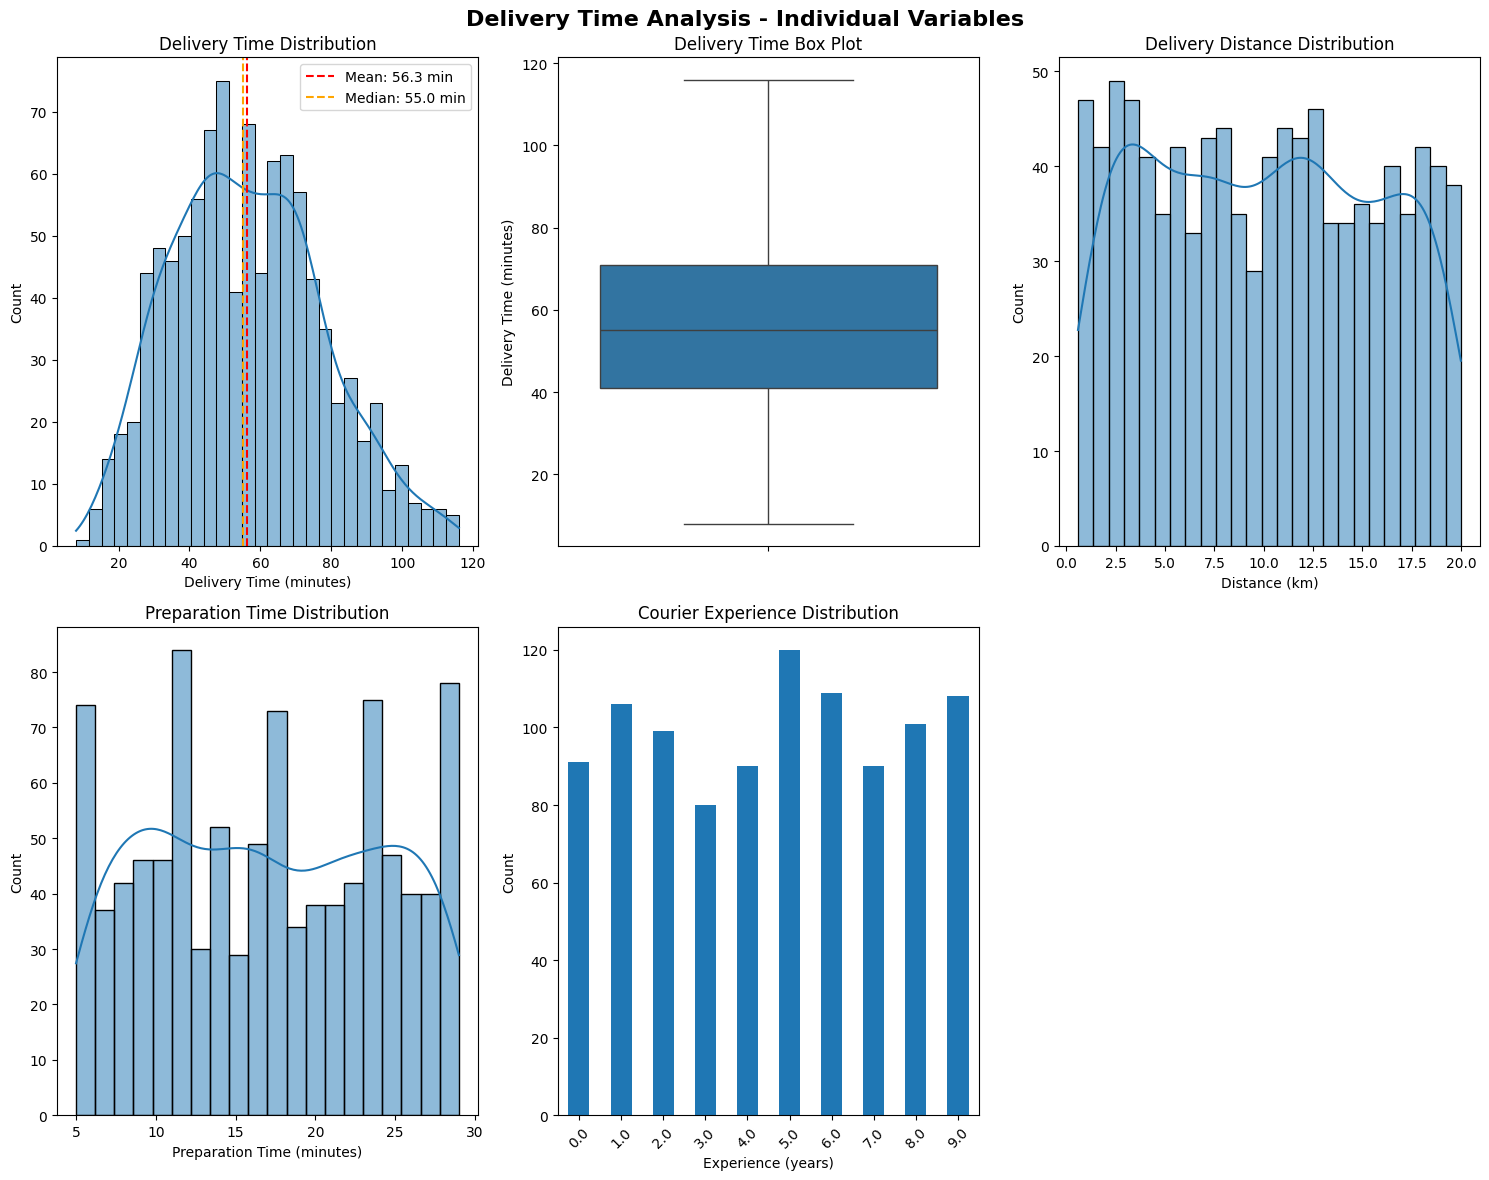

In [ ]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Delivery Time Analysis - Individual Variables', fontsize=16, fontweight='bold')

# Target variable distribution
ax1 = axes[0, 0]
sns.histplot(data=df_clean, x='Delivery_Time_min', bins=30, kde=True, ax=ax1)
ax1.set_title('Delivery Time Distribution')
ax1.set_xlabel('Delivery Time (minutes)')
ax1.axvline(df_clean['Delivery_Time_min'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df_clean["Delivery_Time_min"].mean():.1f} min')
ax1.axvline(df_clean['Delivery_Time_min'].median(), color='orange', linestyle='--',
           label=f'Median: {df_clean["Delivery_Time_min"].median():.1f} min')
ax1.legend()

# outlier check with box plot
ax2 = axes[0, 1]
sns.boxplot(data=df_clean, y='Delivery_Time_min', ax=ax2)
ax2.set_title('Delivery Time Box Plot')
ax2.set_ylabel('Delivery Time (minutes)')

# Distance distribution
ax3 = axes[0, 2]
sns.histplot(data=df_clean, x='Distance_km', bins=25, kde=True, ax=ax3)
ax3.set_title('Delivery Distance Distribution')
ax3.set_xlabel('Distance (km)')

# Preparation time distribution
ax4 = axes[1, 0]
sns.histplot(data=df_clean, x='Preparation_Time_min', bins=20, kde=True, ax=ax4)
ax4.set_title('Preparation Time Distribution')
ax4.set_xlabel('Preparation Time (minutes)')

# Courier experience distribution
ax5 = axes[1, 1]
# Count plot works better for discrete values
experience_counts = df_clean['Courier_Experience_yrs'].value_counts().sort_index()
experience_counts.plot(kind='bar', ax=ax5)
ax5.set_title('Courier Experience Distribution')
ax5.set_xlabel('Experience (years)')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=45)

#remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

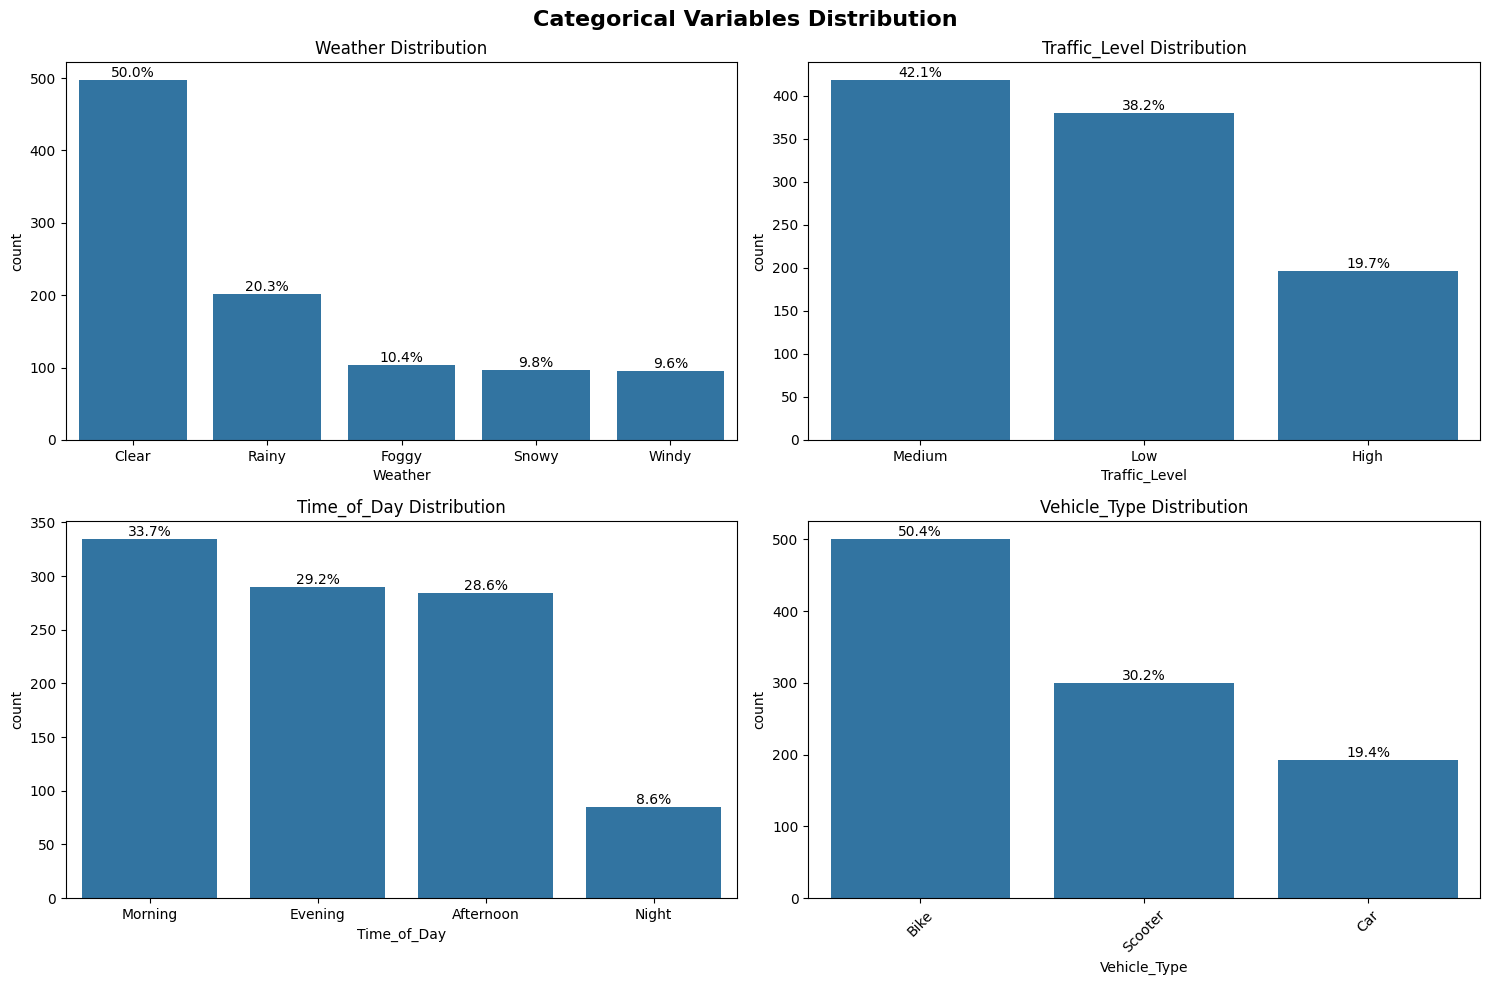

In [ ]:
# visualization of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Categorical Variables Distribution', fontsize=16, fontweight='bold')

categorical_vars = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

for i, var in enumerate(categorical_vars):
    ax = axes[i//2, i%2]
    
    # Count plot
    order = df_clean[var].value_counts().index  # Order by frequency
    sns.countplot(data=df_clean, x=var, order=order, ax=ax)
    ax.set_title(f'{var} Distribution')
    
    # percentage labels easier interpretation
    total = len(df_clean)
    for p in ax.patches:
        percentage = f'{100*p.get_height()/total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')
    
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

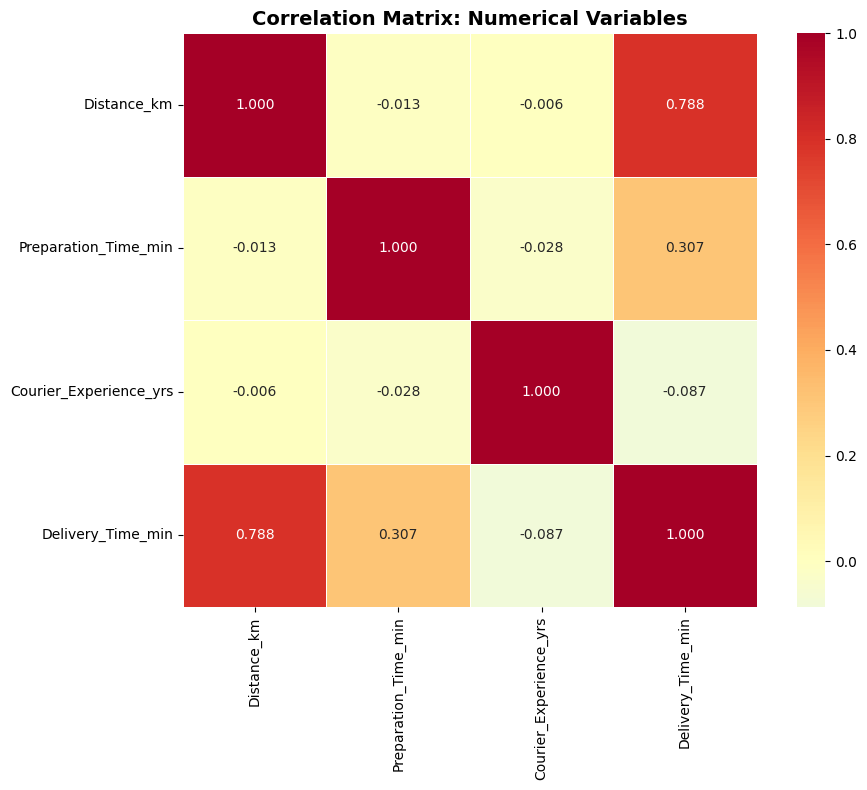

CORRELATION INSIGHTS(for target feature):
Distance_km: Positive Strong (0.788)
Preparation_Time_min: Positive Moderate (0.307)
Courier_Experience_yrs: Negative Weak (-0.087)


In [ ]:
# Correlation matrix
numerical_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[numerical_cols].corr()

# hetmap
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            cmap='RdYlBu_r',     
            center=0,            
            square=True,          
            linewidths=0.5,       
            fmt='.3f')            

plt.title('Correlation Matrix: Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# AUTOMATIC INTERPRETATION
print("CORRELATION INSIGHTS(for target feature):")
target_corr = correlation_matrix['Delivery_Time_min'].drop('Delivery_Time_min').sort_values(key=abs, ascending=False)
for var, corr in target_corr.items():
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.3 else "Weak"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"{var}: {direction} {strength} ({corr:.3f})")

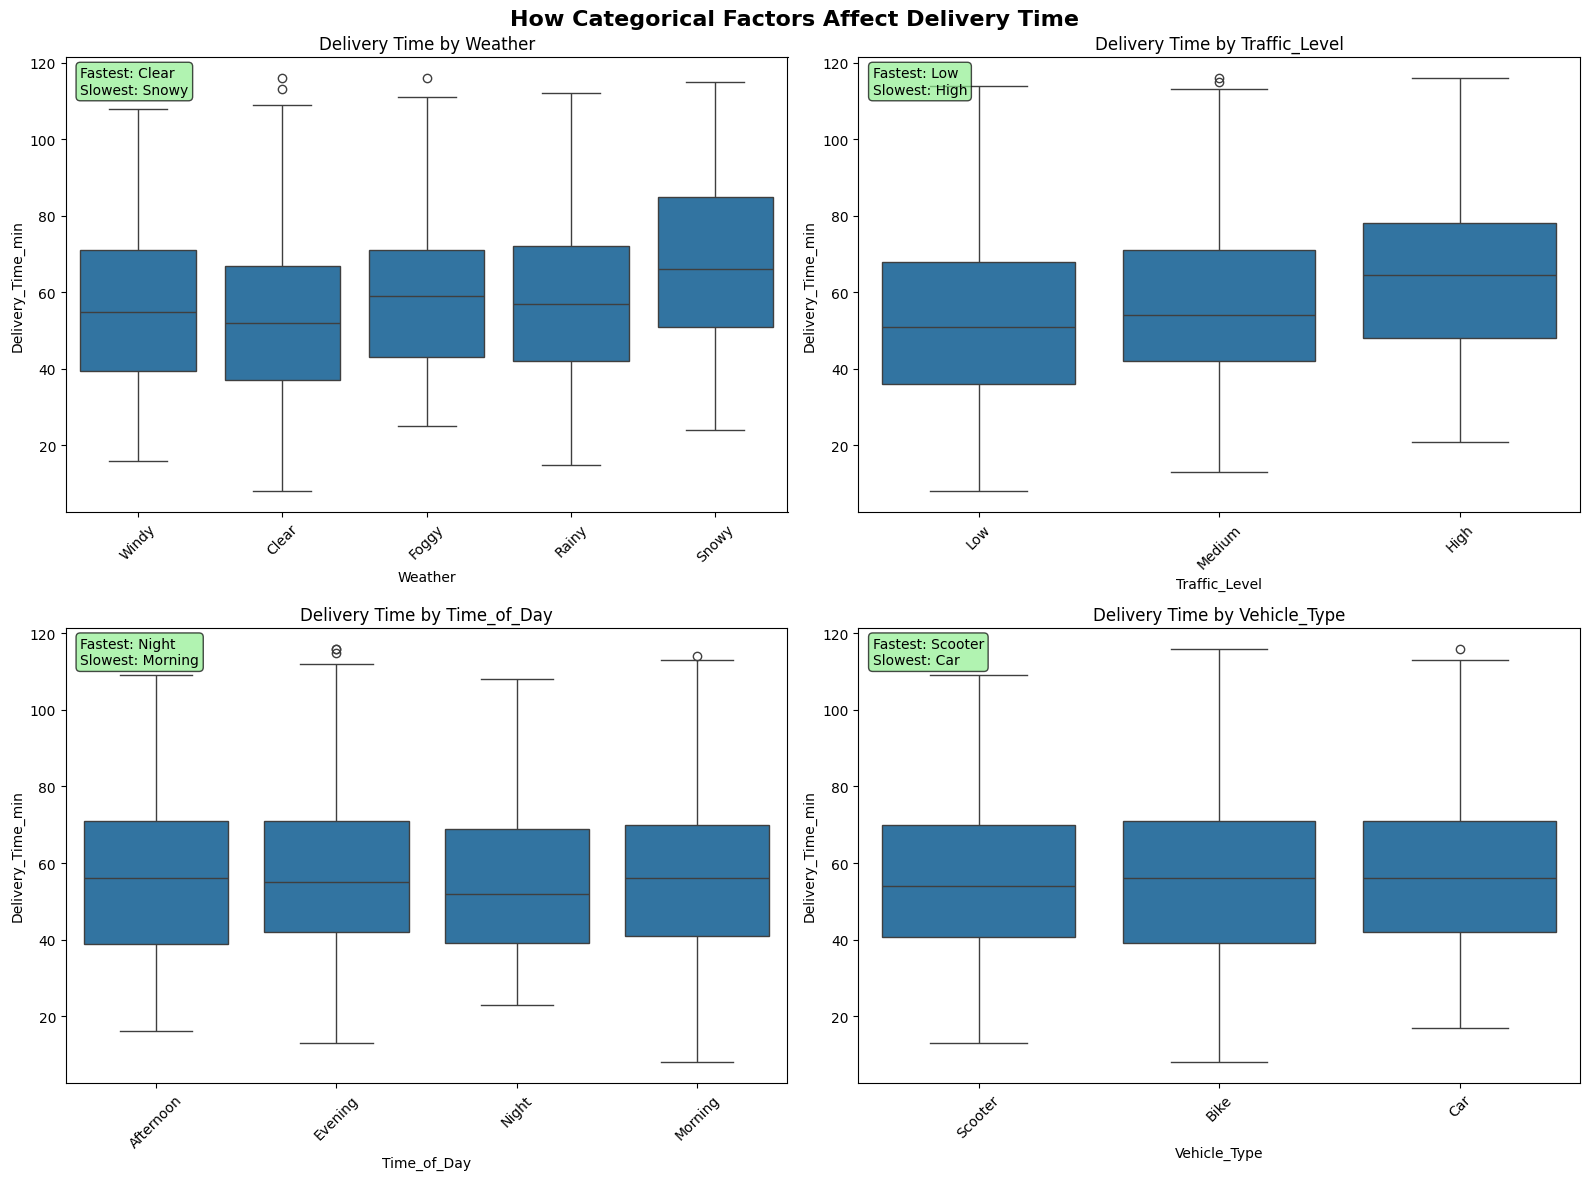

In [ ]:
# How categorical factors affect delivery time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('How Categorical Factors Affect Delivery Time', fontsize=16, fontweight='bold')

#Pick out categorical variables 
categorical_vars =df.select_dtypes(include=['object']).columns.tolist()

for i, cat_var in enumerate(categorical_vars):
    ax = axes[i//2, i%2] # subplot position
    
    # Box plots
    sns.boxplot(data=df_clean, x=cat_var, y='Delivery_Time_min', ax=ax)
    ax.set_title(f'Delivery Time by {cat_var}')
    ax.tick_params(axis='x', rotation=45)
    
    # Add annotations for fastest and slowest categories
    medians = df_clean.groupby(cat_var)['Delivery_Time_min'].median().sort_values()
    fastest = medians.index[0]
    slowest = medians.index[-1]
    
    ax.text(0.02, 0.98, f'Fastest: {fastest}\nSlowest: {slowest}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7)) #Aesthetic for box

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

print("Statistical Significance Tests")
for cat_var in categorical_vars:
    groups = [group['Delivery_Time_min'].values  for _, group in df_clean.groupby(cat_var)]
    
    # ANOVA test for multiple groups
    f_stat, p_value = stats.f_oneway(*groups)
    
    significance = "Significant" if p_value < 0.05 else "Not Significant"
    print(f"{cat_var}: F={f_stat:.2f}, p={p_value:.4f} ({significance})")


Statistical Significance Tests
Weather: F=12.01, p=0.0000 (Significant)
Traffic_Level: F=22.53, p=0.0000 (Significant)
Time_of_Day: F=0.13, p=0.9451 (Not Significant)
Vehicle_Type: F=0.48, p=0.6203 (Not Significant)


In [ ]:
print("Caregorical Relationships:")
# Weather vs Traffic patterns
weather_traffic = pd.crosstab(df_clean['Weather'], df_clean['Traffic_Level'], normalize='index') * 100
print("Weather vs Traffic Patterns:")
print(weather_traffic.round(1))

# Time vs Vehicle patterns
time_vehicle = pd.crosstab(df_clean['Time_of_Day'], df_clean['Vehicle_Type'], normalize='index') * 100
print("\nTime vs Vehicle Patterns:")  
print(time_vehicle.round(1))

# traffic vs Time of Day patterns
traffic_time = pd.crosstab(df_clean['Time_of_Day'], df_clean['Traffic_Level'], normalize='index') * 100
print("\nTraffic vs Time of Day Patterns:")  
print(traffic_time.round(1))

Caregorical Relationships:
Weather vs Traffic Patterns:
Traffic_Level  High   Low  Medium
Weather                          
Clear          17.9  37.2    44.9
Foggy          20.4  45.6    34.0
Rainy          21.8  38.6    39.6
Snowy          20.6  45.4    34.0
Windy          23.2  27.4    49.5

Time vs Vehicle Patterns:
Vehicle_Type  Bike   Car  Scooter
Time_of_Day                      
Afternoon     49.3  18.7     32.0
Evening       51.4  16.9     31.7
Morning       47.2  23.3     29.6
Night         63.5  15.3     21.2

Traffic vs Time of Day Patterns:
Traffic_Level  High   Low  Medium
Time_of_Day                      
Afternoon      20.4  41.9    37.7
Evening        18.6  37.2    44.1
Morning        19.7  37.6    42.7
Night          21.2  31.8    47.1


In [ ]:
# One-Hot Encoding of Categorical Variables
df_features = df_clean.copy()

categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()

# get_dummies for this task where there is no particular order or hierarchy
df_encoded = pd.get_dummies(df_features, 
                           columns=categorical_cols,    
                           prefix=categorical_cols,     
                           drop_first=False)           

df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [ ]:
from scipy.stats import chi2_contingency
# Reload original data to analyze missing patterns
df_original = pd.read_csv("Food_Delivery_Times.csv")

# Check if missing values occur together (systematic vs random)
missing_mask = df_original[['Weather', 'Traffic_Level', 'Time_of_Day', 'Courier_Experience_yrs']].isnull()
missing_combinations = missing_mask.groupby(list(missing_mask.columns)).size()
print("Missing value combinations:")
print(missing_combinations)

# Test if missing values are random (Little's MCAR test approximation)
def missing_pattern_analysis(df):
    missing_df = df.isnull()
    # Check correlation between missingness patterns
    missing_corr = missing_df.corr()
    print("\nCorrelation between missing value patterns:")
    print(missing_corr)
    
    # Chi-square test for independence of missing patterns
    for col1 in missing_df.columns:
        for col2 in missing_df.columns:
            if col1 < col2:  # Avoid duplicates
                contingency = pd.crosstab(missing_df[col1], missing_df[col2])
                if contingency.size > 1:  # Only test if variation exists
                    chi2, p_value, _, _ = chi2_contingency(contingency)
                    print(f"{col1} vs {col2}: Chi2={chi2:.3f}, p={p_value:.4f}")

missing_pattern_analysis(df_original[['Weather', 'Traffic_Level', 'Time_of_Day', 'Courier_Experience_yrs']])

Missing value combinations:
Weather  Traffic_Level  Time_of_Day  Courier_Experience_yrs
False    False          False        False                     883
                                     True                       29
                        True         False                      28
         True           False        False                      29
                        True         False                       1
True     False          False        False                      28
                                     True                        1
                        True         False                       1
dtype: int64

Correlation between missing value patterns:
                         Weather  Traffic_Level  Time_of_Day  \
Weather                 1.000000      -0.030928     0.003436   
Traffic_Level          -0.030928       1.000000     0.003436   
Time_of_Day             0.003436       0.003436     1.000000   
Courier_Experience_yrs  0.003436      -0.030928    -0.030928  